# **NECESSARY IMPORTS**

In [1]:
import pickle
import numpy as np

In [2]:
!pip install torchinfo

In [3]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
from torch.utils.data.dataloader import DataLoader

# Import matplotlib for visualization
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Check versions
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.1+cu121
torchvision version: 0.17.1+cu121


# **DEVICE AGNOSTICS**

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **UNPACK DATASET IN REQUIRED FORMAT**

In [5]:
def unpickle(file):
  with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
  return dict

In [6]:
def unpickle_class(file):
  with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
  return dict

In [7]:
batch1=unpickle("/content/data_batch_1")
batch2=unpickle("/content/data_batch_2")
batch3=unpickle("/content/data_batch_3")
batch4=unpickle("/content/data_batch_4")
batch5=unpickle("/content/data_batch_5")
test_batch=unpickle("/content/test_batch")

In [8]:
class_name=unpickle_class("/content/batches.meta")


In [9]:
batch1_data=batch1[b'data']
batch2_data=batch2[b'data']
batch3_data=batch3[b'data']
batch4_data=batch4[b'data']
batch5_data=batch5[b'data']
test_batch_data=test_batch[b'data']
batch1_label=batch1[b'labels']
batch2_label=batch2[b'labels']
batch3_label=batch3[b'labels']
batch4_label=batch4[b'labels']
batch5_label=batch5[b'labels']
test_batch_label=test_batch[b'labels']
class_names=class_name['label_names']

In [10]:
class_name['label_names']

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# **CONCATENATE BATCHES**

In [11]:
ls2=np.concatenate((batch1_data, batch2_data))
ls3=np.concatenate((ls2,batch3_data))
ls4=np.concatenate((ls3,batch4_data))
final_batch=np.concatenate((ls4,batch5_data))
final_batch.shape

(50000, 3072)

In [12]:
lb2=np.concatenate((batch1_label, batch2_label))
lb3=np.concatenate((lb2,batch3_label))
lb4=np.concatenate((lb3,batch4_label))
final_label=np.concatenate((lb4,batch5_label))
final_label.shape

(50000,)

# **CONVERT DATA INTO TORCH TENSOR**

In [13]:
d=torch.Tensor(final_batch)
#i=d.type(torch.int64)

m=torch.Tensor(test_batch_data)
#n=m.type(torch.int64)

# **DATA RESHAPE AND NORMALISATION**

In [14]:
e=torch.reshape(d,(50000,3,32,32))
t=torch.reshape(m,(10000,3,32,32))

In [15]:
e = e / 255.0
t = t /255.0

# **MERGE DATA AND LABELS**

In [16]:
def merge(list1, list2):

    merged_list = tuple(zip(list1, list2))
    return merged_list

In [17]:
train_data=merge(e,final_label)
test_data=merge(t,test_batch_label)
#test_data

# **DATA LOADER**

In [18]:
batch_size=32

train = DataLoader(train_data, batch_size, shuffle=True)
test = DataLoader(test_data, batch_size, shuffle=False)

In [19]:
train_features_batch, train_labels_batch = next(iter(train))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Image shape: torch.Size([50000, 3, 32, 32])


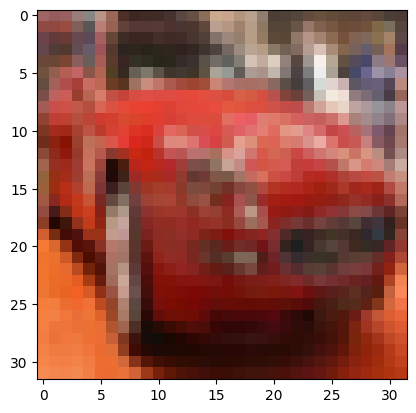

In [20]:
print(f"Image shape: {e.shape}")
plt.imshow(e[5].permute(1,2,0))

# **VIEW IMAGES**

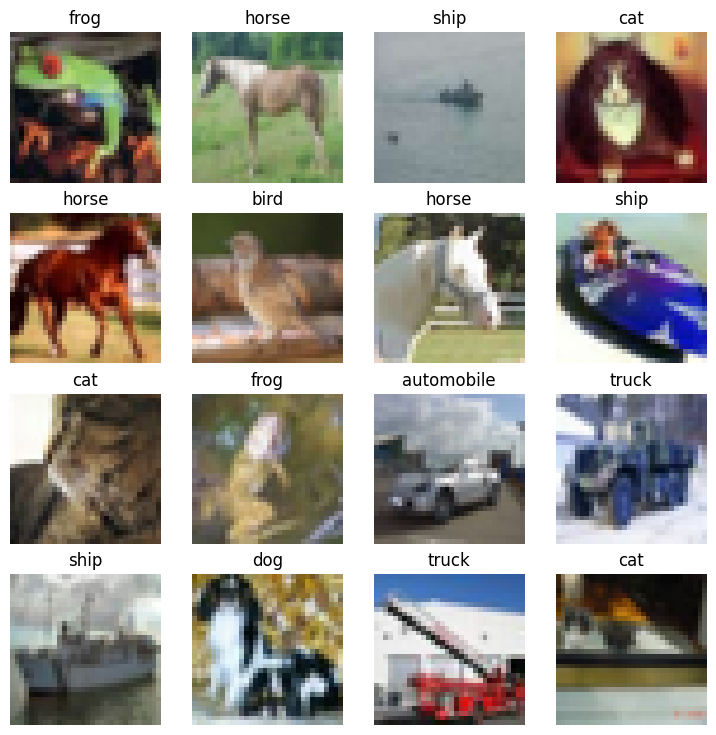

In [21]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img = e[random_idx]
    label= final_label[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# **CNN MODEL**

In [22]:

class Classifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.MaxPool2d(2, 2),
            nn.Dropout(0.40),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.40),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.40),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.Linear(1024, 512),
            nn.Linear(512, 128),
            nn.Linear(128, 10)

        )
    def forward(self, x):
        return self.network(x)

torch.manual_seed(42)
model = Classifier().to(device)
model

Classifier(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.4, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (12): ReLU()
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.4, inplace=False)


In [23]:
summary(Classifier())

Layer (type:depth-idx)                   Param #
Classifier                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       896
│    └─ReLU: 2-2                         --
│    └─BatchNorm2d: 2-3                  64
│    └─Conv2d: 2-4                       9,248
│    └─ReLU: 2-5                         --
│    └─BatchNorm2d: 2-6                  64
│    └─MaxPool2d: 2-7                    --
│    └─Dropout: 2-8                      --
│    └─Conv2d: 2-9                       18,496
│    └─ReLU: 2-10                        --
│    └─BatchNorm2d: 2-11                 128
│    └─Conv2d: 2-12                      36,928
│    └─ReLU: 2-13                        --
│    └─BatchNorm2d: 2-14                 128
│    └─MaxPool2d: 2-15                   --
│    └─Dropout: 2-16                     --
│    └─Conv2d: 2-17                      73,856
│    └─ReLU: 2-18                        --
│    └─BatchNorm2d: 2-19                 256
│    └─C

# **LOSS FUNCTION AND OPTIMISER**

In [24]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.001)

# **TRAINING AND EVALUATION**

In [25]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):

        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )


        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [26]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
torch.manual_seed(42)


# Train and test model
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.91505 | Train accuracy: 29.90%
Test loss: 1.86619 | Test accuracy: 30.70%

Epoch: 1
---------
Train loss: 1.47884 | Train accuracy: 45.97%
Test loss: 1.40770 | Test accuracy: 49.35%

Epoch: 2
---------
Train loss: 1.23864 | Train accuracy: 55.62%
Test loss: 1.14331 | Test accuracy: 58.84%

Epoch: 3
---------
Train loss: 1.07609 | Train accuracy: 61.70%
Test loss: 1.08276 | Test accuracy: 61.53%

Epoch: 4
---------
Train loss: 0.95723 | Train accuracy: 66.19%
Test loss: 0.96926 | Test accuracy: 65.75%

Epoch: 5
---------
Train loss: 0.86236 | Train accuracy: 69.78%
Test loss: 0.93390 | Test accuracy: 67.48%

Epoch: 6
---------
Train loss: 0.78254 | Train accuracy: 72.70%
Test loss: 0.88757 | Test accuracy: 68.38%

Epoch: 7
---------
Train loss: 0.71663 | Train accuracy: 74.95%
Test loss: 0.79935 | Test accuracy: 71.68%

Epoch: 8
---------
Train loss: 0.65632 | Train accuracy: 77.05%
Test loss: 0.82382 | Test accuracy: 70.90%

Epoch: 9
---------
Train los

In [268]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')

# **WEB APPLICATION**

In [269]:
%%writefile app.py
import streamlit as st
import torch
import cv2
import torchvision.transforms as transforms



@st.cache(allow_output_mutation=True)
def load_model():
  model = torch.jit.load('model_scripted.pt')

  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # IMAGE CLASSIFICATION
         """
         )

file = st.file_uploader("Upload the Image", type=["jpg", "png"])
import cv2
from PIL import Image, ImageOps
import numpy as np
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):

        size = (32,32)
        image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
        img=np.asarray(image)
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        transform = transforms.Compose([transforms.ToTensor()])
        tensor = transform(image)
        p=tensor.unsqueeze(0)
        a=p.to('cuda')
        prediction = model(a)
        q=torch.argmax(prediction)
        class_names1=['airplane', 'automobile','bird','cat', 'deer', 'dog', 'frog','horse','ship','truck']
        ans=class_names1[q]
        return ans

if file is None:
    st.text("Please upload an image file")
else:
    image = Image.open(file)
    st.image(image, use_column_width=True)
    predict = import_and_predict(image, model)
    class_names1=['Airplane', 'Automobile','Bird','Cat', 'Deer', 'Dog', 'Frog','Horse','Ship','Truck']
    string="Image is "+ predict
    st.success(string)


Overwriting app.py


In [261]:
! pip install streamlit -q
!wget -q -O - ipv4.icanhazip.com
! streamlit run app.py & npx localtunnel --port 8501

35.197.67.178



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.67.178:8501

npx: installed 22 in 2.428s
your url is: https://ninety-hats-wait.loca.lt
2024-04-28 19:34:11.108 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
2024-04-28 19:34:11.110 
════════════════════════════════════════════════
deprecation.showfileUploaderEncoding IS NO LONGER SUPPORTED.

deprecation.showfileUploaderEncoding has been deprecated and will be removed in a future version.

Please update <user defined>.
════════════════════════════════════════════════

2024-04-28 19:34:20.236 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-fea